In [83]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [84]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.metrics import balanced_accuracy_score

In [85]:
# Load the wine dataset
dataset_path = '/content/drive/MyDrive/000_Set_de_datos/winequality-white.csv'
wine_data = pd.read_csv(dataset_path, sep=";")
wine_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [86]:
# Checking unique values in the 'quality' column (these are labels)
wine_data['quality'].unique()

array([6, 5, 7, 8, 4, 3, 9])

In [87]:
#Checking for missing values in the dataset
wine_data.isnull().sum()

,0
fixed acidity,0
volatile acidity,0
citric acid,0
residual sugar,0
chlorides,0
free sulfur dioxide,0
total sulfur dioxide,0
density,0
pH,0
sulphates,0


In [88]:
# Count the number of occurrences for each quality level
wine_data['quality'].value_counts()

# We can see that the dataset is imbalaced.
# This means that some classes have significantly more samples than others.

,count
quality,
6,2198
5,1457
7,880
8,175
4,163
3,20
9,5


In [89]:
# Create a new column 'quality_label' with binary classification
wine_data['quality_label'] = (wine_data['quality'] > 6).astype(int)


# ⚠️ Important Note:
#The dataset had 6 quality levels, but was binarized for simplicity (1 = good, 0 = bad/medium).
# Wines with quality > 6 are labeled as 1 (good), and those with quality ≤ 6 as 0 (bad/medium).

In [90]:
# Split the dataset: 70% for training and 30% for testing
train_data, test_data = train_test_split(wine_data, test_size=0.3, random_state=123, stratify=wine_data['quality_label'])
#Using stratify=y, we ensure that the proportion of each class is maintained when splitting the data into training and test sets.

# Separate features (X) and labels (y) for training and testing sets
X_train = train_data.drop(columns=['quality', 'quality_label'])
y_train = train_data['quality_label']
X_test = test_data.drop(columns=['quality', 'quality_label'])
y_test = test_data['quality_label']

# Fit the scaler ONLY on the training data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit and transform on train set
X_test = scaler.transform(X_test)  # Transform test set using the same scaler

# From the TRAIN set, split again: 70% for validation training and 30% for validation testing
train_val_data, test_val_data = train_test_split(train_data, test_size=0.3, random_state=123)

In [91]:
# Separate features (X) and labels (y) for the validation training and validation testing sets
X_train_val = train_val_data.drop(columns=['quality', 'quality_label'])
y_train_val = train_val_data['quality_label']
X_test_val = test_val_data.drop(columns=['quality', 'quality_label'])
y_test_val = test_val_data['quality_label']

# Standardize validation data using the same scaler fitted on training data
X_train_val = scaler.transform(X_train_val)  # Apply the same scaler from X_train
X_test_val = scaler.transform(X_test_val)  # Apply the same scaler from X_test

In [92]:
print("Unique values in y_train_val:", np.unique(y_train_val))
print("Unique values in y_test_val:", np.unique(y_test_val))

Unique values in y_train_val: [0 1]
Unique values in y_test_val: [0 1]


# Proceed to search for the best hyperparameters for our Logistic Regression.

In [93]:
# Define the hyperparameter values to test
C_values = [0.01, 0.1, 1, 10, 100]
solvers = ['liblinear', 'lbfgs', 'saga']

In [94]:
# Initialize variables to store the best results
best_accuracy = 0
best_f1 = 0
best_params = {}

# Nested loop to test all combinations of C and solver
for C in C_values:
    for solver in solvers:
        # Create and train the model with the current hyperparameters
        try:
            log_reg = LogisticRegression(C=C, solver=solver, max_iter=5000, class_weight="balanced", random_state=123)
            log_reg.fit(X_train_val, y_train_val)

            # Predict on the validation set
            y_pred = log_reg.predict(X_test_val)

            # Calculate performance metrics
            accuracy = accuracy_score(y_test_val, y_pred)
            f1 = f1_score(y_test_val, y_pred)
            balanced_accuracy_log = balanced_accuracy_score(y_test_val, y_pred)

            # Display the current results
            print(f'Solver: {solver}, C: {C}, Accuracy: {accuracy}, F1-Score: {f1}, Balanced Accuracy: {balanced_accuracy_log}')

            # Store the best results
            if f1 > best_f1:
                best_f1 = f1
                best_accuracy = accuracy
                best_balanced_accuracy = balanced_accuracy_log
                best_params = {'C': C, 'solver': solver}
        except Exception as e:
            print(f'Error training the model with solver: {solver}, C: {C}. Error: {str(e)}')


# Display the best obtained results
print(f'\nBest Hyperparameters: {best_params}')
print(f'Best Accuracy: {best_accuracy}')
print(f'Best F1-Score: {best_f1}')
print(f'Best Balanced Accuracy: {best_balanced_accuracy}')

Solver: liblinear, C: 0.01, Accuracy: 0.7084548104956269, F1-Score: 0.5222929936305732, Balanced Accuracy: 0.7231946558430576
Solver: lbfgs, C: 0.01, Accuracy: 0.7201166180758017, F1-Score: 0.5294117647058824, Balanced Accuracy: 0.7272704211060375
Solver: saga, C: 0.01, Accuracy: 0.7201166180758017, F1-Score: 0.5294117647058824, Balanced Accuracy: 0.7272704211060375
Solver: liblinear, C: 0.1, Accuracy: 0.7016520894071915, F1-Score: 0.5040387722132472, Balanced Accuracy: 0.7055470996110265
Solver: lbfgs, C: 0.1, Accuracy: 0.7055393586005831, F1-Score: 0.5073170731707317, Balanced Accuracy: 0.7080162354134957
Solver: saga, C: 0.1, Accuracy: 0.7055393586005831, F1-Score: 0.5073170731707317, Balanced Accuracy: 0.7080162354134957
Solver: liblinear, C: 1, Accuracy: 0.7045675413022352, F1-Score: 0.5032679738562091, Balanced Accuracy: 0.7040673093184509
Solver: lbfgs, C: 1, Accuracy: 0.7035957240038873, F1-Score: 0.5008183306055647, Balanced Accuracy: 0.7017842042956198
Solver: saga, C: 1, Acc

# Now I will proceed to test against a Decision Tree Classification model

In [95]:
# Initialize variables to store the best results
best_accuracy = 0
best_balanced_accuracy = 0
best_f1 = 0
best_depth = 5

# Test different tree depths to find the best hyperparameter tuning using the validation train and test sets
depth = range(5, 51, 5)
for i in depth:
    arbol = DecisionTreeClassifier(max_depth=i,class_weight="balanced", random_state=123)
    arbol.fit(X_train_val, y_train_val)
    y_pred = arbol.predict(X_test_val)
    acc_arbol = accuracy_score(y_test_val, y_pred)
    f1_arbol = f1_score(y_test_val, y_pred, average='weighted')
    balanced_accuracy_arbol = balanced_accuracy_score(y_test_val, y_pred)

    # Store the best results
    if acc_arbol > best_accuracy:
        best_accuracy = acc_arbol
        best_f1 = f1_arbol
        best_balanced_accuracy = balanced_accuracy_arbol
        best_depth = i

# Display the best obtained results
print(f'\nBest Hyperparameters: {best_depth}')
print(f'Best Accuracy: {best_accuracy}')
print(f'Best F1-Score: {best_f1}')
print(f'Best Balanced Accuracy: {best_balanced_accuracy}')
print("Unique predicted values:", np.unique(y_pred, return_counts=True))


Best Hyperparameters: 25
Best Accuracy: 0.8095238095238095
Best F1-Score: 0.808880615650042
Best Balanced Accuracy: 0.7124302384576358
Unique predicted values: (array([0, 1]), array([814, 215]))


# Now I will proceed to test against Random Tree Forest model

In [96]:
# ================== DEFINE HYPERPARAMETER GRID ==================
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20],  # Maximum depth of trees
    'min_samples_split': [2, 5, 10],  # Min samples to split a node
    'min_samples_leaf': [1, 2, 4]  # Min samples per leaf
}

# ================== RUN GRID SEARCH ==================
grid_search = GridSearchCV(
    RandomForestClassifier(class_weight="balanced", random_state=123),
    param_grid,
    scoring='accuracy',  # Optimize for accuracy
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Use all available CPU cores
    verbose=2  # Show progress
)

grid_search.fit(X_train_val, y_train_val)  # Train on validation train set

# ================== GET BEST PARAMETERS ==================
best_params = grid_search.best_params_
print("\nBest Parameters:", best_params)

# ================== TRAIN FINAL MODEL WITH BEST HYPERPARAMETERS ==================
best_rf_model = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    class_weight="balanced",
    random_state=123
)

best_rf_model.fit(X_train_val, y_train_val)
y_pred_rf = best_rf_model.predict(X_test_val)

# ================== EVALUATE FINAL MODEL ==================
rf_accuracy = accuracy_score(y_test_val, y_pred_rf)
rf_f1 = f1_score(y_test_val, y_pred_rf, average='weighted')
rf_balanced_accuracy = balanced_accuracy_score(y_test_val, y_pred_rf)

# Print results
print(f"\nOptimized Random Forest Model Performance:")
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"F1-Score: {rf_f1:.4f}")
print(f"Balanced Accuracy: {rf_balanced_accuracy:.4f}")

# Print detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test_val, y_pred_rf))

Fitting 5 folds for each of 81 candidates, totalling 405 fits

Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}

Optimized Random Forest Model Performance:
Accuracy: 0.8601
F1-Score: 0.8547
Balanced Accuracy: 0.7579

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.91       810
           1       0.71      0.58      0.64       219

    accuracy                           0.86      1029
   macro avg       0.80      0.76      0.78      1029
weighted avg       0.85      0.86      0.85      1029



# Finally, I will review how a KNN model performs

In [97]:
# Initialize variables to store the best results
best_accuracy = 0
best_balanced_accuracy = 0
best_f1 = 0
best_nei = 5
best_wei = ''

# Define the values for hyperparameter tuning
nei = [5, 10, 20, 40, 60, 61, 62, 63, 64, 65, 80, 100]
wei = ['uniform', 'distance']

# Loop through all combinations of hyperparameters
for i in nei:
    for j in wei:
        knn = KNeighborsClassifier(n_neighbors=i, weights=j)
        knn.fit(X_train_val, y_train_val)
        y_pred = knn.predict(X_test_val)
        acc_knn = accuracy_score(y_test_val, y_pred)
        f1_knn = f1_score(y_test_val, y_pred, average='weighted')
        bal_acc_knn = balanced_accuracy_score(y_test_val, y_pred)

        # Store the best results
        if acc_knn > best_accuracy:
            best_accuracy = acc_knn
            best_f1 = f1_knn
            best_balanced_accuracy = bal_acc_knn
            best_nei = i
            best_wei = j

# Display the best obtained results
print(f'\nBest Hyperparameters: {best_nei}, {best_wei}')
print(f'Best Accuracy: {best_accuracy}')
print(f'Best F1-Score: {best_f1}')
print(f'Best Balanced Accuracy: {best_balanced_accuracy}')
print("Unique predicted values:", np.unique(y_pred, return_counts=True))


Best Hyperparameters: 40, distance
Best Accuracy: 0.858114674441205
Best F1-Score: 0.8451918678681588
Best Balanced Accuracy: 0.7199729409775072
Unique predicted values: (array([0, 1]), array([929, 100]))


# After reviewing the Accuracy / F1 / Balanced Accuracy of each model:


*  Logistic Regression: 0.7201 / F1 = 0.5294 / Balanced accuracy = 0.7272
*  Decision Tree Classifier: 0.8095 / F1 = 0.8088 / Balanced accuracy = 0.7124
*  Random Forest: 0.8601 / F1 = 0.8547 / Balanced accuracy = 0.7579
*  K-Nearest Neighbors Classifier: 0.8581 / F1 = 0.8581 / Balanced accuracy = 0.7199


# We can conclude that the most appropriate model for predicting wine quality in the winequality-white dataset is Random Forest model

In [98]:
final_rf_model = RandomForestClassifier(
    n_estimators=100,  # Best found: 100
    max_depth=None,  # Best found: None
    min_samples_leaf=2,  # Best found: 2
    min_samples_split=5,  # Best found: 5
    class_weight="balanced",  # Handle class imbalance
    random_state=123
)

final_rf_model.fit(X_train, y_train)  # Train on the full dataset

# ================== EVALUATE FINAL MODEL ==================
# Predict on the same dataset (since we're using 100% for training)
y_pred_final = final_rf_model.predict(X_test)

# Compute final metrics
final_accuracy = accuracy_score(y_test, y_pred_final)
final_f1 = f1_score(y_test, y_pred_final, average="weighted")

# Print final performance
print(f'\nFinal Model Performance (Trained on 100% of the data):')
print(f'Final Accuracy: {final_accuracy:.4f}')
print(f'Final F1-Score: {final_f1:.4f}')

# Print detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_final))


Final Model Performance (Trained on 100% of the data):
Final Accuracy: 0.8585
Final F1-Score: 0.8555

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1152
           1       0.69      0.62      0.65       318

    accuracy                           0.86      1470
   macro avg       0.80      0.77      0.78      1470
weighted avg       0.85      0.86      0.86      1470



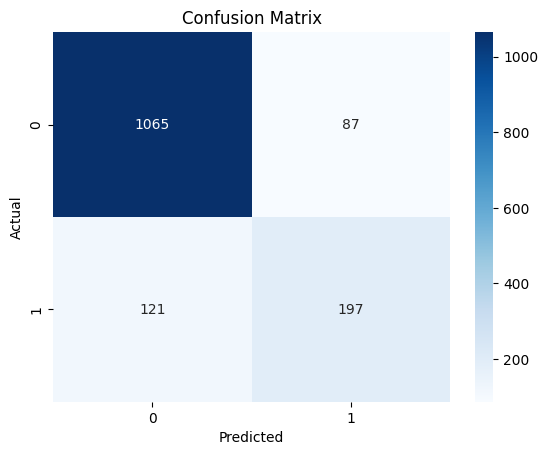

In [99]:
cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()


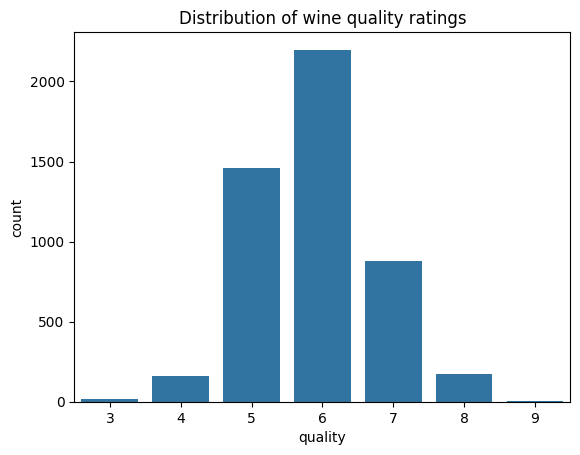

In [100]:
# Distribution of wine quality ratings

sns.countplot(x='quality', data=wine_data)
plt.title('Distribution of wine quality ratings')
plt.savefig("wine_quality_score_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

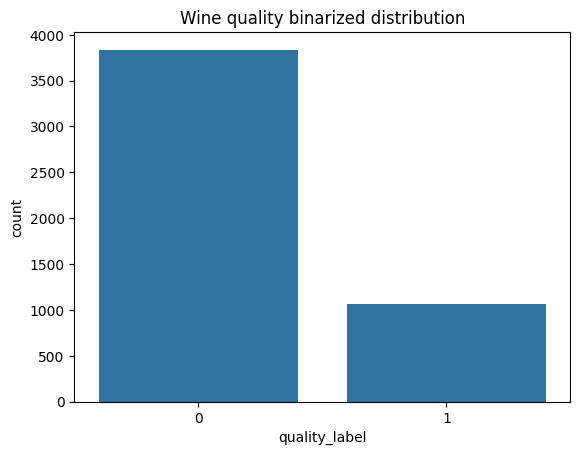

In [82]:
# Distribution of binary wine quality (Good vs bad)
sns.countplot(x='quality_label', data=wine_data)
plt.title('Wine quality binarized distribution')
plt.savefig("distribution_of_binary_wine_quality.png", dpi=300, bbox_inches='tight')
plt.show()


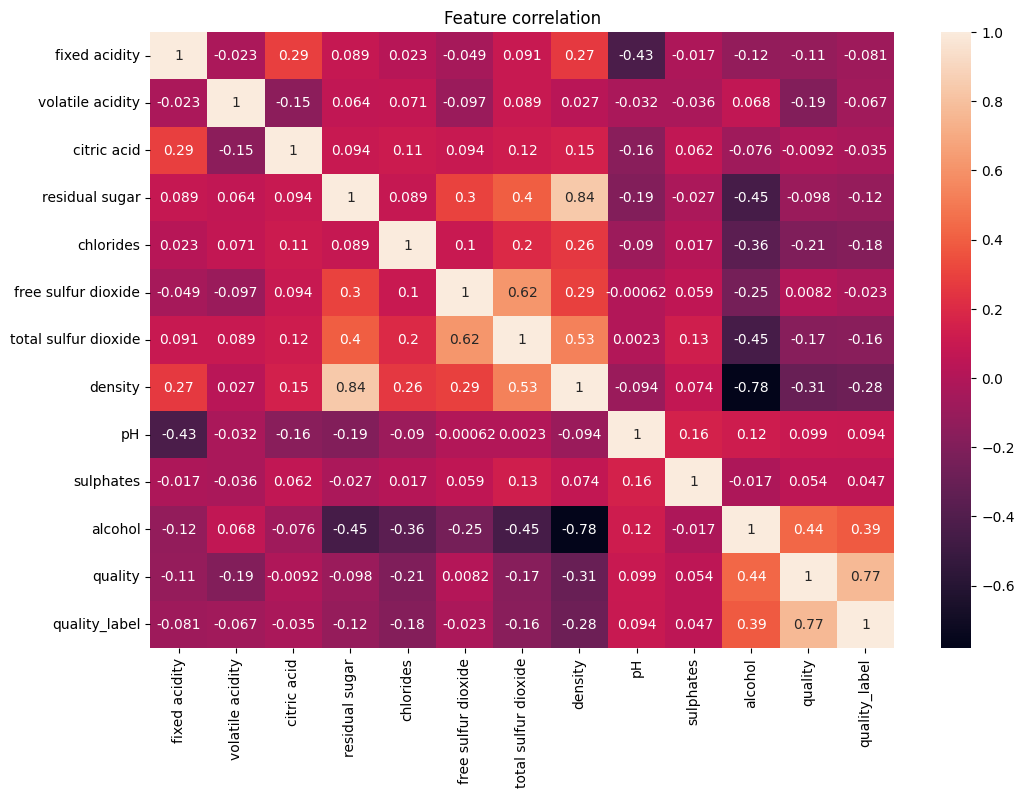

In [101]:
plt.figure(figsize=(12, 8))
sns.heatmap(wine_data.corr(), annot=True)
plt.title('Feature correlation')
plt.savefig("feature_correlation.png", dpi=300, bbox_inches='tight')
plt.show()


In [36]:
# 🔍 Key Observations from the Correlation Matrix:
# 1️⃣ Alcohol content has the highest positive correlation with wine quality (0.44).
#     - This means wines with higher alcohol levels tend to have better quality.
# 2️⃣ pH has a moderate negative correlation with quality (-0.10).
#     - Lower pH (higher acidity) is slightly associated with better wine quality.
# 3️⃣ Density is negatively correlated with quality (-0.17).
#     - Wines with lower density tend to have better quality (likely due to lower residual sugar).
# 4️⃣ The 'quality_label' column has a correlation of 0.77 with 'quality'.
#     - This confirms that the binarization of the 'quality' variable was correctly applied.

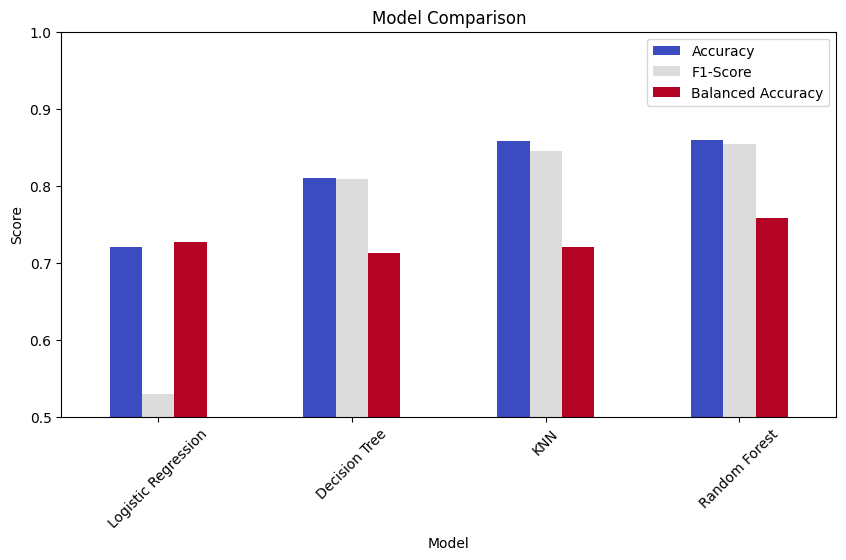

In [79]:
metrics_df = pd.DataFrame({
    "Model": ["Logistic Regression", "Decision Tree", "KNN", "Random Forest"],
    "Accuracy": [0.7201, 0.8095, 0.8581, 0.8601],
    "F1-Score": [0.5294, 0.8088, 0.8451, 0.8547],
    "Balanced Accuracy": [0.7272, 0.7124, 0.7199, 0.7579]
})

metrics_df.set_index("Model").plot(kind="bar", figsize=(10,5), colormap="coolwarm")
plt.title("Model Comparison")
plt.ylabel("Score")
plt.ylim(0.5, 1.0)
plt.xticks(rotation=45)
plt.savefig("model_comparison.png", dpi=300, bbox_inches='tight')
plt.show()